<a href="https://colab.research.google.com/github/erichsiao1106/models/blob/master/plant_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
class_map = {'Charlock':0, 'Cleavers': 1, 'Fat Hen': 2, 'Maize': 3}

drive/My Drive/class/北分署/week8/seed/Cleavers/33c1f167f.png


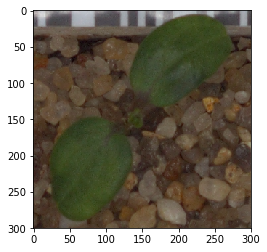

In [ ]:
# Read single image
data_path = 'drive/My Drive/class/北分署/week8/seed/*/*.png' 
img_paths = glob(data_path)
# img_paths = np.random.choice(img_paths, 50) # demo for 50 images
img = cv2.imread(img_paths[0])[:,:,::-1]
print(img_paths[0])
plt.imshow(img)

((300, 300, 3), (128, 128, 3))

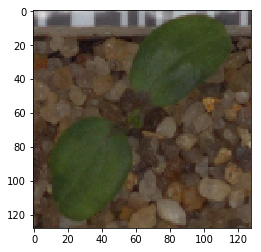

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/class/北分署/week8/seed/Cleavers/33c1f167f.png'

In [ ]:
cls = img_path.split('/')[-2]
cls

'Cleavers'

## 1. Read all data

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ), dtype=int)
print(f'total images: {data_count}')

total images: 1373


In [ ]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)[:,:,::-1]
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [ ]:
X = X/255
y_onehot = keras.utils.to_categorical(y, num_classes=4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1098, 128, 128, 3), (275, 128, 128, 3), (1098, 4), (275, 4))

In [ ]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 390, 1: 287, 2: 475, 3: 221}

## 2. Use Data Generator and Augmentation

In [ ]:
path_train, path_test = train_test_split(img_paths, test_size=0.2, random_state=5566)

In [ ]:
# imgaug 
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(-45, 45),
        mode=ia.ALL, # edge, reflect, symmetric, warp, constant
        shear=(-16,16)
    )
])

# Data Generator
def data_generator(data_paths, batch_size, aug, preprocess=None):
    class_map = {'Charlock':0, 'Cleavers': 1, 'Fat Hen': 2, 'Maize': 3}
    '''data generator for fit_generator'''
    n = len(data_paths)
    i = 0
    data_paths = data_paths
    while True:
        image_data = []
        class_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(data_paths)
            path = data_paths[i]
            img = cv2.imread(path)[:,:,::-1]
            # img aug
            if aug:
                img = seq.augment_image(img)
            else:
                img = img / 255
            
            # img preprocess
            img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            if preprocess:
                img_resize = preprocess(img_resize)
            # read label
            cls = path.split('/')[-2]
            cls = class_map[cls]
            cls = to_categorical(cls, num_classes=len(class_map))

            image_data.append(img_resize)
            class_data.append(cls)
            i = (i+1) % n
        image_data = np.array(image_data)
        class_data = np.array(class_data)
        if preprocess:
            image_data = preprocess(image_data)
        yield image_data, class_data

## Build Model

In [ ]:
# 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation=keras.activations.relu)(x)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [ ]:
# 2
from keras.applications.resnet50 import preprocess_input
base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), )
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_map), activation='softmax')(x)
model = Model(base_model.input, predictions)

# freeze layers
for layers in base_model.layers:
    layers.trainable = False

#model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Training

In [ ]:
train_gen = data_generator(path_train, batch_size=BATCH_SIZE, aug=True, preprocess=preprocess_input)
test_gen = data_generator(path_test, batch_size=BATCH_SIZE, aug=False, preprocess=preprocess_input)

In [ ]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# 1. train with all data
# logs = model.fit(X_train, y_train,
#                 batch_size=BATCH_SIZE,
#                 epochs=100,
#                 verbose=1,
#                 callbacks=[],     
#                 validation_data=(X_test, y_test))

# 2. train with data generator
logs = model.fit_generator(train_gen,
                           steps_per_epoch=np.ceil(len(path_train)/BATCH_SIZE),
                           epochs=100,
                           verbose=1,
                           callbacks=[early_stopping, reduce_lr],     
                           validation_data=test_gen,
                           validation_steps=np.ceil(len(path_test)/BATCH_SIZE),
                           )

Epoch 1/100
35/35 [==============================] - 31s 873ms/step - loss: 0.9459 - acc: 0.6080 - val_loss: 1.8860 - val_acc: 0.3681
Epoch 2/100
35/35 [==============================] - 20s 579ms/step - loss: 0.5400 - acc: 0.8071 - val_loss: 2.7179 - val_acc: 0.3299
Epoch 3/100
35/35 [==============================] - 23s 647ms/step - loss: 0.4046 - acc: 0.8634 - val_loss: 2.8335 - val_acc: 0.3507
Epoch 4/100
35/35 [==============================] - 23s 659ms/step - loss: 0.3284 - acc: 0.8813 - val_loss: 2.5787 - val_acc: 0.3299

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
35/35 [==============================] - 19s 536ms/step - loss: 0.2925 - acc: 0.8964 - val_loss: 2.3345 - val_acc: 0.3438
Epoch 6/100
35/35 [==============================] - 23s 654ms/step - loss: 0.2634 - acc: 0.8973 - val_loss: 2.4405 - val_acc: 0.3368
Epoch 00006: early stopping


In [ ]:
history = logs.history

Text(0.5, 1.0, 'acc')

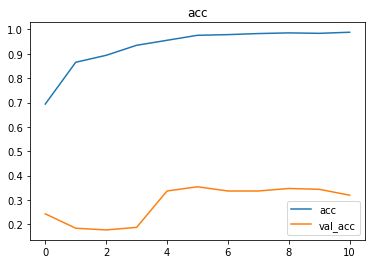

In [ ]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

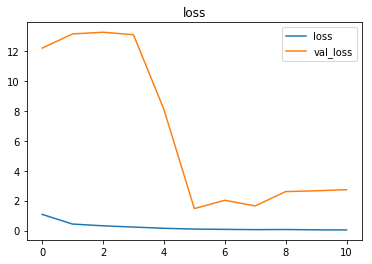

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(4)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(275,) (275,)
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        68
           1       0.92      0.86      0.89        64
           2       0.90      0.92      0.91        93
           3       0.93      0.80      0.86        50

    accuracy                           0.89       275
   macro avg       0.90      0.88      0.89       275
weighted avg       0.89      0.89      0.89       275

[[64  2  2  0]
 [ 3 55  5  1]
 [ 2  3 86  2]
 [ 7  0  3 40]]
